#### Import functions, etc.

In [1]:
from functions import compute_mcp, compute_proximity_density

import numpy as np
import pandas as pd
import binet as bnt
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/home/miglesia/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### load data
#### Time periods are chosen as 4 year, contiguous, non-overlapping periods

In [2]:
data = pd.read_csv('./Boschma2018Dataset')
data['time_period'] = np.round((data.year - data.year.min() + 0.001)/4.).astype(int)
df = data.groupby(['ccode','pcode','time_period']).sum()['export_val'].reset_index()

## Compute RCA, proximity, density, ECI, PCI

In [3]:
time_periods = np.sort(df.time_period.unique())

year_column = 'time_period'

#Create Mcp matrices
mcp_ys = []
fi = []
w = []
ECI = []
PCI = []
mcp_co_list = []
mcp_pr_list = []
RCA = []

for tp in time_periods:
    RCA_y = bnt.calculateRCA(df.loc[df[year_column] == tp], c='ccode',p='pcode',x='export_val')
    RCA_y['RCA_bin'] = (RCA_y['RCA'] > 1).astype(int)
    RCA_y[year_column] = tp
    
    mcp_y = compute_mcp(RCA_y.loc[RCA_y[year_column] == tp])
    mcp_ys += [mcp_y]
    RCA += [RCA_y]
    
    fi_y, w_y = compute_proximity_density(mcp_y, time_period_value = tp)

    fi += [fi_y]  
    w += [w_y]
    
    # Compute complexity
    
    mcp = mcp_y[(mcp_y.T != 0).any()]
    mcp = mcp.T[(mcp != 0).any()].T
    mcp.sort_index(axis=0, inplace=True)
    mcp.sort_index(axis=1, inplace=True)
    
    ECI_y, PCI_y = bnt.CalculateComplexity(mcp.as_matrix())  
    PCI_y = [ -pc for pc in PCI_y]
    ECI_y = pd.DataFrame(ECI_y, index = mcp.index, columns = ['ECI']).reset_index()
    PCI_y = pd.DataFrame(PCI_y, index = mcp.columns, columns = ['PCI']).reset_index()
    
    ECI_y['time_period'] = tp; PCI_y['time_period'] = tp
    
    ECI += [ECI_y]
    PCI += [PCI_y]
    
    mcp_co_list += [mcp.index]
    mcp_pr_list += [mcp.columns]
        
RCA, fi, w, ECI, PCI = pd.concat(RCA), pd.concat(fi), pd.concat(w), pd.concat(ECI), pd.concat(PCI)


### Does proximity to other products depend on complexity?

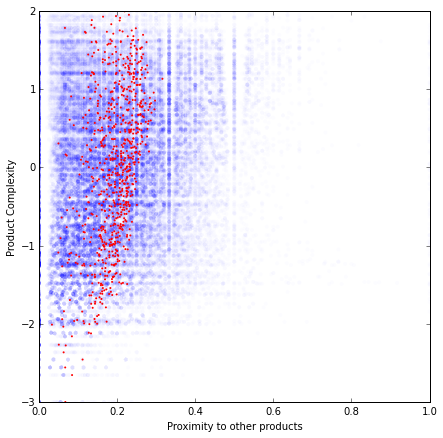

In [4]:
fi_PCI = fi.merge(PCI, left_on = ['p_source', 'time_period'], right_on = ['pcode', 'time_period'])
fi_PCI_sample = fi_PCI.loc[fi_PCI.time_period == 11].sample(80000)
pts = fi_PCI_sample[['PCI', 'proximity']]
pts_mean = pts.groupby('PCI').mean()

plt.figure(figsize = (7, 7))
plt.scatter(pts.proximity.values, pts.PCI.values, edgecolors = 'None', s = 20, alpha = 0.01, label = '')
plt.scatter(pts_mean.proximity.values, pts_mean.index, edgecolors = 'None', s = 4, c = 'r')
plt.xlabel('Proximity to other products')
plt.ylabel('Product Complexity')
plt.xlim(0, 1)
plt.ylim(-3, 2)
plt.show()

### Option sets, relative density and complexity

In [5]:
#Observations in 'option sets' are those for which RCA < 1
option_sets = RCA.loc[RCA.RCA_bin == 0][['ccode', 'pcode', 'time_period']]

#Add density and complexity information to the obss. in option set
df = option_sets.merge(PCI, on = ['pcode', 'time_period']).merge(w, on = ['pcode', 'ccode', 'time_period'])

# Relative density and complexity are computed as z-scores from the groups of undeveloped products
zscore = lambda x: (x - x.mean()) / x.std()
df.insert(5, 'rel_PCI', df.groupby(['ccode', 'time_period'])['PCI'].transform(zscore))
df.insert(6, 'rel_w', df.groupby(['ccode', 'time_period'])['density'].transform(zscore))


### Compute correlation of relative density and complexity for all time periods and countries

In [6]:
correlation_df = pd.DataFrame(df.groupby(['ccode', 'time_period'])[['rel_PCI','rel_w']].corr().ix[0::2,'rel_w'])
correlation_df.index = correlation_df.index.droplevel(2)
correlation_df.columns = ['rel_w_PCI_correlation']
correlation_df.reset_index(inplace=True)

### Full list of countries by correlation of density and PCI in the option set

In [7]:
pd.set_option('display.max_rows', None)

co = pd.read_csv('./co.csv')
correlation_df.loc[correlation_df.time_period == 12].sort_values(by = 'rel_w_PCI_correlation', ascending = False).merge(co)

,ccode,time_period,rel_w_PCI_correlation,name
0,jpn,12,0.924454,Japan
1,che,12,0.897641,Switzerland
2,deu,12,0.859090,Germany
3,aut,12,0.799186,Austria
4,swe,12,0.772703,Sweden
5,fin,12,0.756462,Finland
6,gbr,12,0.738702,United Kingdom
7,usa,12,0.688601,United States
8,kor,12,0.675417,South Korea
9,fra,12,0.658753,France


### Choose country and time period and plot relative density and PCI

0.675416938381


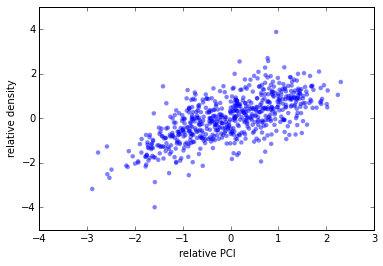

In [8]:
ccode = 'kor'
x = df.loc[df.ccode == ccode].loc[df.time_period == 12]
# x = df.sample(10000)

plt.scatter(x.rel_PCI, x.rel_w, edgecolor = 'None', alpha = 0.5)
plt.xlabel('relative PCI')
plt.ylabel('relative density')

print x.PCI.corr(x.density, method='pearson', min_periods=100)

### Plot selected countries: time progress of correlation of relative PCI and w.

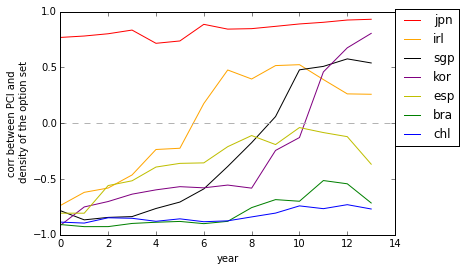

In [9]:
ccodes = ['jpn', 'irl', 'sgp', 'kor', 'esp', 'bra','chl']
colors = ['r','orange','k','purple','y','g','b']
for i in range(len(ccodes)): 
    x = correlation_df.loc[correlation_df.ccode == ccodes[i]]
    plt.plot(x.time_period, x.rel_w_PCI_correlation, label = ccodes[i], color = colors[i])
    plt.legend(loc = (1,.4))
    
plt.axhline(0, linestyle = '--', c = '.7')
plt.xlabel('year')
plt.ylabel('corr between PCI and \n density of the option set')
plt.show()

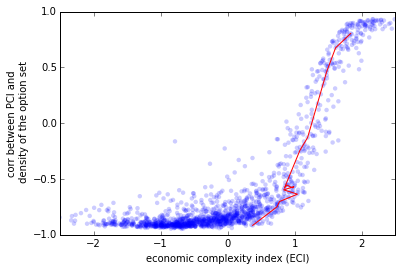

In [10]:
x = correlation_df.merge(ECI, on = ['ccode', 'time_period'])
highlight_ccode = 'kor'

#Points
plt.scatter(x.ECI, x.rel_w_PCI_correlation, edgecolor = 'None', alpha = 0.2)

#Highlight
plt.plot(x.loc[x.ccode == highlight_ccode].ECI, x.loc[x.ccode == highlight_ccode].rel_w_PCI_correlation, color = 'r')

plt.xlim(-2.5, 2.5)
plt.ylim(-1, 1)
plt.xlabel('economic complexity index (ECI)')
plt.ylabel('corr between PCI and \n density of the option set')
plt.show()